In [2]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# helper functions

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]

def make_2D(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        key_list = []
        for e in series[key]:
            key_list.append([e]) # try brackets here
        l.append(key_list)
    return l

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (7.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (5.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (3.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (1.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def eval(pred, truth):
    o_pred = []
    o_truth = []
    f_pred = []
    f_truth = []
    b_pred = []
    b_truth = []
    s_pred = []
    s_truth = []
    l_pred = []
    l_truth = []
    for p in pred:
        o_pred.append(p[0])
        f_pred.append(p[1])
        b_pred.append(p[2])
        s_pred.append(p[3])
        l_pred.append(p[4])
    for t in truth:
        o_truth.append(t[0])
        f_truth.append(t[1])
        b_truth.append(t[2])
        s_truth.append(t[3])
        l_truth.append(t[4])
    return [[E0(o_pred, o_truth), E1(o_pred, o_truth), E2(o_pred, o_truth), E3(o_pred, o_truth)],
            [E0(f_pred, f_truth), E1(f_pred, f_truth), E2(f_pred, f_truth), E3(f_pred, f_truth)],
            [E0(b_pred, b_truth), E1(b_pred, b_truth), E2(b_pred, b_truth), E3(b_pred, b_truth)],
            [E0(s_pred, s_truth), E1(s_pred, s_truth), E2(s_pred, s_truth), E3(s_pred, s_truth)],
            [E0(l_pred, l_truth), E1(l_pred, l_truth), E2(l_pred, l_truth), E3(l_pred, l_truth)]]

In [4]:
# loading data

X_train_list = []
y_train_list = []

X_test_list = []
y_test_list = []

with open("..\\test_examples.txt") as t:
    test_examples = t.readlines()

for example in test_examples:
    series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])
    x_example = make_2D(series)
    y_example = [float(example[4]) / 9, float(example[7]) / 9, float(example[10]) / 9, float(example[13]) / 9, float(example[16]) / 9]
    X_test_list.append(x_example)
    y_test_list.append(y_example)

X_test = torch.tensor(X_test_list)
y_test = torch.tensor(y_test_list)
print(X_test.size())
print(y_test.size())

with open("..\\training_examples.txt") as t:
    training_examples = t.readlines()

for example in training_examples:
    series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])
    x_example = make_2D(series)
    y_example = [float(example[4]) / 9, float(example[7]) / 9, float(example[10]) / 9, float(example[13]) / 9, float(example[16]) / 9]
    X_train_list.append(x_example)
    y_train_list.append(y_example)

X_train = torch.tensor(X_train_list)
y_train = torch.tensor(y_train_list)
print(X_train.size())
print(y_train.size())

print('\n')

# N H W C  TO  N C H W

X_train = X_train.permute(0, 1, 2, 3)
X_test = X_test.permute(0, 1, 2, 3)

torch.Size([93, 32, 7, 1])
torch.Size([93, 5])
torch.Size([371, 32, 7, 1])
torch.Size([371, 5])




In [18]:
# setting up big ResNet

fc_size1 = 128
fc_size2 = 256
fc_size3 = 128
fc_size4 = 64
fc_size5 = 20
output_size = 5
batch_size = 371
learning_rate = 0.001
tmp = 0.1
    

class BigResNet(nn.Module):

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(1.0)

    def __init__(self):
        super(BigResNet, self).__init__()
        self.apply(self._init_weights)
        # conv layers
        self.conv1 = nn.Conv2d(32, 40, (3,1), stride=1, padding=(1,0))
        self.conv2 = nn.Conv2d(40, 48, (3,1), stride=1, padding=(1,0))
        self.conv3 = nn.Conv2d(48, 56, (3,1), stride=1, padding=(1,0))
        self.conv4 = nn.Conv2d(56, 64, (3,1), stride=1, padding=(1,0))
        self.conv5 = nn.Conv2d(64, 72, (3,1), stride=1, padding=(1,0))
        self.conv6 = nn.Conv2d(72, 80, (3,1), stride=1)
        self.conv7 = nn.Conv2d(80, 88, (3,1), stride=1, padding=(1,0))
        self.conv8 = nn.Conv2d(88, 96, (3,1), stride=1, padding=(1,0))
        self.conv9 = nn.Conv2d(96, 104, (3,1), stride=1, padding=(1,0))
        self.conv10 = nn.Conv2d(104, 112, (3,1), stride=1)
        self.conv11 = nn.Conv2d(112, 120, (3,1), stride=1, padding=(1,0))
        self.conv12 = nn.Conv2d(120, 128, (3,1), stride=1)
        # residual connections
        self.res1 = nn.Conv2d(40, 48, (1,1), stride=1)
        self.res2 = nn.Conv2d(48, 56, (1,1), stride=1)
        self.res3 = nn.Conv2d(56, 64, (1,1), stride=1)
        self.res4 = nn.Conv2d(64, 72, (1,1), stride=1)
        self.res5 = nn.Conv2d(80, 88, (1,1), stride=1)
        self.res6 = nn.Conv2d(88, 96, (1,1), stride=1)
        self.res7 = nn.Conv2d(96, 104, (1,1), stride=1)
        self.res8 = nn.Conv2d(112, 120, (1,1), stride=1)
        # fc layers
        self.fc1 = nn.Linear(fc_size1, fc_size2)
        self.fc2 = nn.Linear(fc_size2, fc_size3)
        self.fc3 = nn.Linear(fc_size3, fc_size4)
        self.fc4 = nn.Linear(fc_size4, fc_size5)
        self.fc5 = nn.Linear(fc_size5, output_size)
        # sigmoid
        self.sigmoid = nn.Sigmoid()
        self.temperature = tmp
    
    def forward(self, x):
        # residual blocks
        x = F.leaky_relu(self.conv1(x), negative_slope=0.1)

        res_x = self.res1(x)
        x = self.conv2(x)
        x += res_x
        x = F.leaky_relu(x, negative_slope=0.1)

        res_x = self.res2(x)
        x = self.conv3(x)
        x += res_x
        x = F.leaky_relu(x, negative_slope=0.1)

        res_x = self.res3(x)
        x = self.conv4(x)
        x += res_x
        x = F.leaky_relu(x, negative_slope=0.1)

        res_x = self.res4(x)
        x = self.conv5(x)
        x += res_x
        x = F.leaky_relu(x, negative_slope=0.1)

        x = F.leaky_relu(self.conv6(x), negative_slope=0.1)

        res_x = self.res5(x)
        x = self.conv7(x)
        x += res_x
        x = F.leaky_relu(x, negative_slope=0.1)

        res_x = self.res6(x)
        x = self.conv8(x)
        x += res_x
        x = F.leaky_relu(x, negative_slope=0.1)

        res_x = self.res7(x)
        x = self.conv9(x)
        x += res_x
        x = F.leaky_relu(x, negative_slope=0.1)

        x = F.leaky_relu(self.conv10(x), negative_slope=0.1)

        res_x = self.res8(x)
        x = self.conv11(x)
        x += res_x
        x = F.leaky_relu(x, negative_slope=0.1)

        x = F.leaky_relu(self.conv12(x), negative_slope=0.1)


        # fc layers
        x = torch.flatten(x, 1)
        
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc5(x), negative_slope=0.1)

        x = self.sigmoid(x * self.temperature)
        return x

model = BigResNet()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

0.04131269454956055
[[27.956989247311828, 54.83870967741935, 83.87096774193549, 94.6236559139785], [55.913978494623656, 75.26881720430107, 82.79569892473118, 93.54838709677419], [34.40860215053763, 66.66666666666667, 79.56989247311827, 83.87096774193549], [25.806451612903224, 62.365591397849464, 87.09677419354838, 96.7741935483871], [40.86021505376344, 69.89247311827957, 87.09677419354838, 94.6236559139785]]


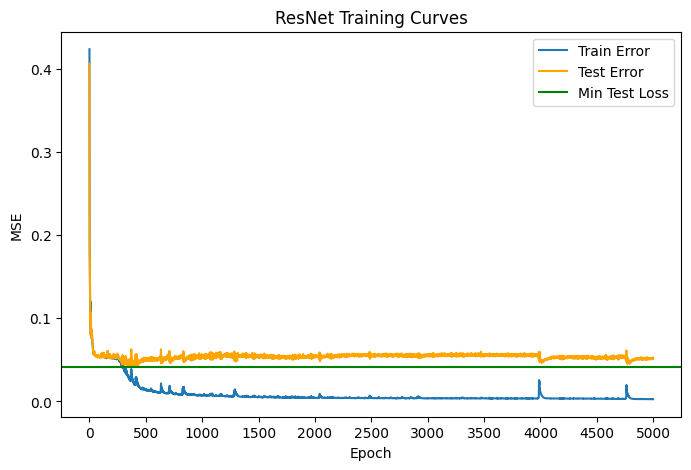

In [23]:
# model training

num_epochs = 500
losses = []
test_losses = []
evaluation = []
min_loss = 1.0
model.apply(model._init_weights)
for epoch in range(num_epochs):
    pred_y = model(X_train)
    loss = loss_function(pred_y, y_train)
    losses.append(loss.item())

    test_y = model(X_test)
    test_loss = loss_function(test_y, y_test)
    test_losses.append(test_loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

    if (test_loss.item() < min_loss):
        min_loss = test_loss.item()
        evaluation.clear()
        evaluation = eval(test_y, y_test)

fig, ax = plt.subplots(1, figsize=(8, 5))

ax.plot(losses, label="Train Error")
ax.plot(test_losses, label="Test Error", c="orange")
ax.set_title("ResNet Training Curves")
ax.set_xticks(np.linspace(0, num_epochs, num=11))

ax.set_ylabel("MSE")
ax.set_xlabel("Epoch")
ax.axhline(min(test_losses), c='g', label='Min Test Loss')
# ax.axvline(85, c='r', label='Training Termination')
ax.legend()
print(min_loss)

print(evaluation)